## 01_visualize_data

Let's visualize different components of our dataset!

### Preamble

In [1]:
%matplotlib ipympl
import sys

import hydra
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torchaudio
import lightning.pytorch as pl
from scipy.stats import gaussian_kde
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import numpy as np


from IPython.display import Audio, display

from pathlib import Path
from egaznepy.visualize import apply_plot_style
from src.data.mocha_timit_datamodule import MTIMITDataModule
from src.models.pitch_module import PitchModule
from src.models.components.metrics import RCAMetric


apply_plot_style(0.9)
plt.rcParams['text.usetex'] = False

root_dir = Path(globals()['_dh'][0]).parent
print(root_dir)
import os
os.chdir(root_dir)

config_path_predict = 'logs/debug/runs/2024-05-29_17-03-54/.hydra/config.yaml'
ckpt_path = 'logs/debug/runs/2024-05-29_17-03-54/checkpoints/epoch_135.ckpt'
config_path_eval = 'logs/eval/runs/2024-06-02_17-08-12/.hydra/config.yaml'

/dataHDD/chsaikeerthi/2024-chirumamilla


### Generate the plots

In [2]:
config_predict = OmegaConf.load(config_path_predict)
datamodule = hydra.utils.instantiate(config_predict.data, slice_length=10)
pitch_module: PitchModule = hydra.utils.instantiate(config_predict.model)

config_eval = OmegaConf.load(config_path_eval)
datamodule = hydra.utils.instantiate(config_eval.data, slice_length=10)
amazon_module: PitchModule = hydra.utils.instantiate(config_eval.model)
del config_predict.trainer.default_root_dir
del config_eval.trainer.default_root_dir
config_predict.trainer.limit_predict_batches = 1

trainer = hydra.utils.instantiate(config_predict.trainer) 
arr_predict = trainer.predict(model=pitch_module, datamodule=datamodule, ckpt_path=ckpt_path)
arr_eval = trainer.predict(model=amazon_module, datamodule=datamodule)

/dataHDD/chsaikeerthi/2024-chirumamilla/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'extractor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['extractor'])`.
/dataHDD/chsaikeerthi/2024-chirumamilla/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.


FileNotFoundError: [Errno 2] No such file or directory: '/dataHDD/chsaikeerthi/2024-chirumamilla/logs/eval/runs/2024-06-02_17-08-12/.hydra/config.yaml'

In [ ]:
# Extract the first 4 elements - our model
pitches_predicted = arr_predict[0][0:4]
pitches_eval = arr_eval[0][0:4]
# gt
corresponding_data = next(iter(datamodule.test_dataloader()))
corresponding_audio = corresponding_data[0][0:4]
pitches_gt = corresponding_data[1][0:4]
pitches_gt = pitch_module.decoder.idx_pitch[pitches_gt.argmax(dim=-1)]

In [ ]:
rca = RCAMetric()
print('Ours', rca(pitches_predicted, pitches_gt))
print('Amazon', rca(pitches_eval, pitches_gt))


Ours tensor(0.8785)
Amazon tensor(0.7975)


pitches_pridict shape
 torch.Size([4, 1000]) ground truth shape
 torch.Size([4, 1000]) ground_truth min
 tensor(62.5000) ground truth max
 tensor(336.8474) predict pitched min 
 tensor(62.5000) predict pitched max 
 tensor(162.0265) pitches_eval shape
 torch.Size([4, 1000]) pitches_eval min
 tensor(62.5000) pitches_eval max
 tensor(224.3115)


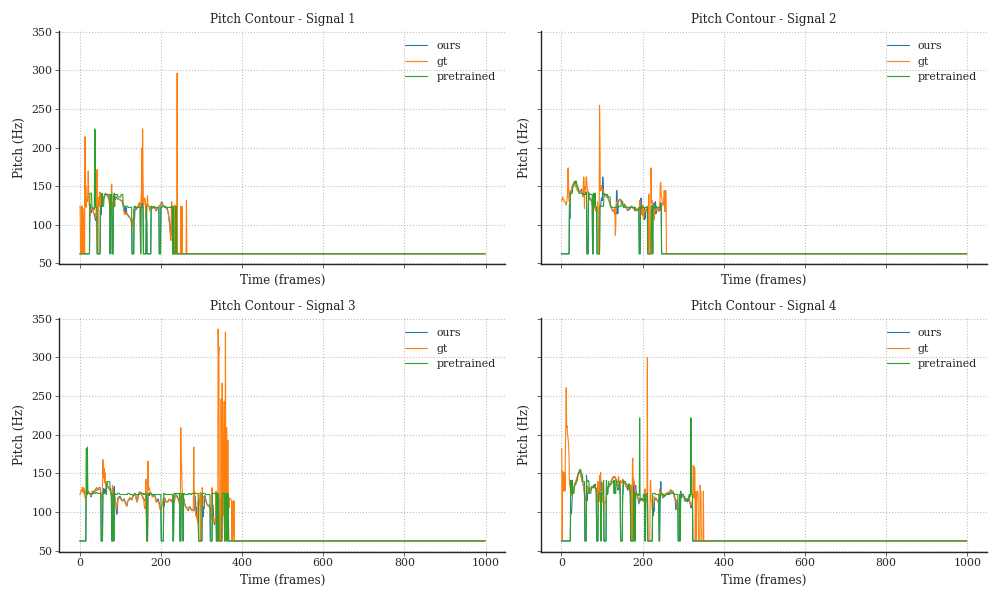

In [ ]:
def plot_pitch_line_subplots(**model_pitches):
    num_signals = len(list(model_pitches.values())[0])
    fig, axs = plt.subplots(num_signals//2, num_signals//2, figsize=(5*num_signals//2, 3*num_signals//2), sharex=True, sharey=True)
    axs = axs.flatten()
    
    for model_name, pitches in model_pitches.items():
        for i, pitch in enumerate(pitches):
            axs[i].plot(pitch, label=model_name)
            axs[i].set_title(f'Pitch Contour - Signal {i + 1}')
            axs[i].set_xlabel('Time (frames)')
            axs[i].set_ylabel('Pitch (Hz)')
            axs[i].grid(True)
            axs[i].legend()      
    
    plt.tight_layout()
    plt.show()


print("pitches_pridict shape\n",pitches_predicted.shape,
      "ground truth shape\n" ,pitches_gt.shape,
      "ground_truth min\n", pitches_gt.min(),
      "ground truth max\n", pitches_gt.max(),
      "predict pitched min \n" ,pitches_predicted.min(),
      "predict pitched max \n", pitches_predicted.max(),
      "pitches_eval shape\n",pitches_eval.shape,
      "pitches_eval min\n",pitches_eval.min(),
      "pitches_eval max\n",pitches_eval.max(),
      )


# Plotting each of the first 4 elements
#fig, axs = plt.subplots(4, 1, figsize=(10, 8))
plot_pitch_line_subplots(ours=pitches_predicted, gt=pitches_gt, pretrained=pitches_eval)

for audio in corresponding_audio:
    display(Audio(audio.squeeze().numpy(), rate=16000))
    

In [ ]:
from opus_binding import LibOPUSBinding
import torchaudio

x ,sr =  torchaudio.load("/dataHDD/chsaikeerthi/2024-chirumamilla/data/TIMIT/SA1ABC0/signal.WAV") 
lib_opus= LibOPUSBinding()
print(x.shape)
x = x[0].numpy()
pitch= lib_opus.extract_pitch(x)
pitch=pitch[0]
print(f"Shape of the loaded pitch values: {pitch_values.shape}")

# Plot the pitch values
plt.figure(figsize=(10, 6))
plt.plot(pitch_values)
plt.title('Pitch Values in Hz')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()


In [ ]:
def collect_data(dataset):
    all_pitches_male = []
    all_probabilities_male = []
    all_pitches_female = []
    all_probabilities_female = []

    for data in dataset:
        speech, pitch, probability, energy, gender = data  # Assuming gender information is available in the dataset
        if gender == "M":
            all_pitches_male.extend(pitch.numpy())
            all_probabilities_male.extend(probability.numpy())
        elif gender == "F":
            all_pitches_female.extend(pitch.numpy())
            all_probabilities_female.extend(probability.numpy())

    return (
        np.array(all_pitches_male), np.array(all_probabilities_male),
        np.array(all_pitches_female), np.array(all_probabilities_female)
    )

# Modify the plotting function to accept data for both male and female
def plot_pitch_probability_histogram(pitches_male, probabilities_male, pitches_female, probabilities_female):
    # Visualize pitch and probability as separate histograms for male and female speakers
    
    plt.figure(figsize=(10, 6))
    plt.hist(pitches_male, bins=500, color='blue', alpha=0.7, label='Male')
    plt.hist(pitches_female, bins=500, color='red', alpha=0.7, label='Female')
    plt.xlabel('Pitch (Hz)')
    plt.ylabel('Probability')
    plt.title('Probability Histogram with Pitch with energy thresholding')
    plt.xlim(0, 600)
    plt.ylim(0, 7500)

    plt.legend()
    plt.grid()
    plt.show()

plot_pitch_probability_histogram(pitches, probabilities)

In [ ]:
import numpy as np
import librosa

def calculate_rms(speech, sample_rate, frame_length=320, hop_length=160):
    pad_length = 320 // 2
    
    # Check if padding is required
    if len(speech) < pad_length:
        raise ValueError("Speech sample is too short for RMS calculation with the given frame_length and pad_length.")
    
    if len(speech) % frame_length != 0:
        # Padding at the end if length is an exact multiple of frame_length
        speech = np.pad(speech, (0, pad_length), mode='constant')
    
    rmse = librosa.feature.rms(y=speech, frame_length=frame_length, hop_length=hop_length, center=False)[0]
    
    return rmse

# Example usage
speech = np.random.randn(74240)  # Example speech array
sample_rate = 16000  # Example sample rate
rmse = calculate_rms(speech, sample_rate)

print(f"RMS shape: {rmse.shape}")


RMS shape: (463,)
